In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDRegressor,SGDClassifier
from sklearn.pipeline import Pipeline
from scipy import sparse
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, MaxAbsScaler,LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
import warnings
import pickle
from nltk.corpus import stopwords
import nltk
import seaborn as sns
import re
import gc
import string
import lightgbm
import pymorphy2
from nltk.tokenize.casual import TweetTokenizer
from mlxtend.text import tokenizer_emoticons
#import spacy
warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных

In [3]:
train =  pd.read_csv('train.csv', sep=',')

In [4]:
test = pd.read_csv('test.csv')

In [5]:
train['fullname_true'].fillna('', inplace=True)
train=train.groupby(['fullname','country'], as_index=False)['target'].max()
train.drop_duplicates(subset=['fullname','target'], inplace=True)
train.reset_index(drop=True, inplace=True)

In [6]:
train.head(10)

,fullname,country,target
0,'ABDULLAYEV DAVUD HASANAGA OGLU,РОССИЯ,1
1,'AZIZOVA DILAFRUZ,РОССИЯ,1
2,'BUTNARU VASILE,РОССИЯ,1
3,'ESHMATOV FARRUKH,РОССИЯ,1
4,'ESHOV ELDOR,РОССИЯ,1
5,'GANEAC ANGELA,РОССИЯ,1
6,'GANIEV AVAZBEK,РОССИЯ,1
7,'HARIPOVA MUTRIGBA,РОССИЯ,1
8,'HASANOV ABDULVORIS NET,РОССИЯ,1
9,'KHURRAMOV ABDUKOSIM,РОССИЯ,1


In [7]:
y=train.target

In [16]:
x_train, x_test, y_train, y_test=train_test_split(train, y, stratify=y, random_state=42)

### KERAS

In [17]:
from keras.layers import Input
from keras.layers.embeddings import Embedding
from keras import optimizers
from keras.layers import Dense, concatenate, Activation, Dropout, SpatialDropout1D, Flatten, LSTM, Merge, Reshape, Bidirectional, GRU
from keras.models import Model, Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPooling1D, MaxPooling1D, GlobalAveragePooling1D

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
from keras.utils import np_utils

Using TensorFlow backend.


In [18]:
#определим число символов в примере
train['char_cnt']=train.fullname.map(lambda x: len(x)) 
test['char_cnt']=test.fullname.map(lambda x: len(x)) 

In [19]:
#посчитаем число слов на пример
train['word_cnt']=train.fullname.map(lambda x: len(x.rstrip().lstrip().split()))
test['word_cnt']=test.fullname.map(lambda x: len(x.rstrip().lstrip().split()))

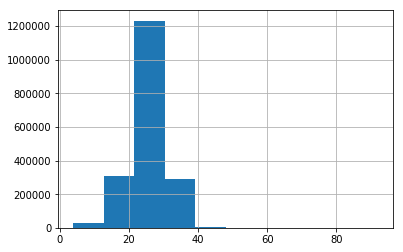

In [20]:
#построим распределение числа символов по документам
#с целью выбора максимального покрытия при кодировании
train['char_cnt'].hist()

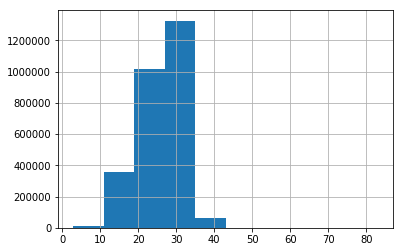

In [21]:
#построим распределение числа символов по документам
#с целью выбора максимального покрытия при кодировании
test['char_cnt'].hist()

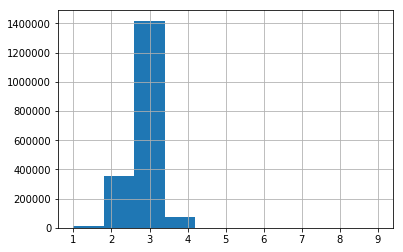

In [22]:
#построим распределение числа слов по документам
#с целью выбора максимального покрытия при кодировании
train['word_cnt'].hist()

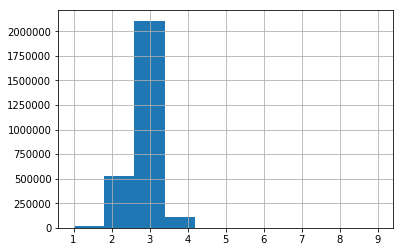

In [23]:
#построим распределение числа слов по документам
#с целью выбора максимального покрытия при кодировании
test['word_cnt'].hist()

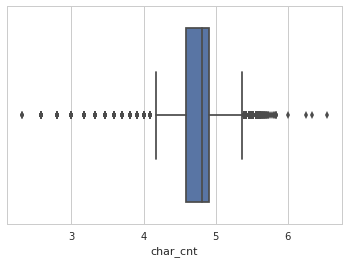

In [24]:
#определим квартили и размах по длинам
sns.set(style="whitegrid")
ax = sns.boxplot(x=np.log2(1+train['char_cnt']))

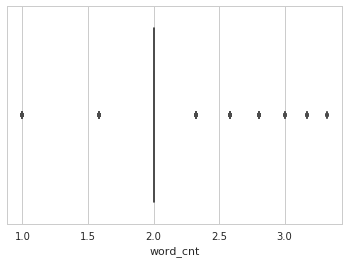

In [25]:
sns.set(style="whitegrid")
ax = sns.boxplot(x=np.log2(1+train['word_cnt']))

#### Prepare datasets for CNN

In [26]:
from os import environ
from collections import Counter
environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [27]:
max_len_char=50
max_len_word=5
num_words=100000 #используем топ num_words слов

In [28]:
#создадим токенайзеры для слов и символов с учетом покрытия слов и алфавита
tokenizer_char=Tokenizer(char_level=True, 
                         filters=None, 
                         num_words=75
                        )

tokenizer_word=Tokenizer(num_words=num_words,
                         char_level=False, 
                         lower=False,
                         filters='')

In [29]:
#обучим их на примерах
tokenizer_char.fit_on_texts(list(pd.concat([train.fullname, test.fullname], axis=0)))
tokenizer_word.fit_on_texts(list(train.fullname))

In [30]:
#произведем кодирование слов и символов one-hot'ом
x_tr_seq_char=tokenizer_char.texts_to_sequences(x_train.fullname)
x_te_seq_char=tokenizer_char.texts_to_sequences(x_test.fullname)
test_seq_char=tokenizer_char.texts_to_sequences(test.fullname)

x_tr_seq_word=tokenizer_word.texts_to_sequences(x_train.fullname)
x_te_seq_word=tokenizer_word.texts_to_sequences(x_test.fullname)
test_seq_word=tokenizer_word.texts_to_sequences(test.fullname)

In [32]:
#отрежем наши последовательности до длинны словаря и алфавита
x_t_ch=pad_sequences(x_tr_seq_char, maxlen=max_len_char)
x_te_ch=pad_sequences(x_te_seq_char, maxlen=max_len_char)
test_ch=pad_sequences(test_seq_char, maxlen=max_len_char)

x_t_w=pad_sequences(x_tr_seq_word, maxlen=max_len_word)
x_te_w=pad_sequences(x_te_seq_word, maxlen=max_len_word)
test_w=pad_sequences(test_seq_word, maxlen=max_len_word)

In [33]:
#склеим наши данные для трейн и тест набора
x_all_ch=np.vstack((x_t_ch,x_te_ch))
x_all_w=np.vstack((x_t_w,x_te_w))

### char-CNN with 2,3,4,5 - ngramms
Построим простенькую CNN сеть реализующую принцип n-gramm при помощи сверток

In [75]:
def model_cnn():
    input_char=Input(shape=(max_len_char,),  dtype='int32')
    embed_size=200
    x=Embedding(len(tokenizer_char.word_index)+1,
                embed_size, 
                input_length=max_len_char)(input_char)

    branches = []
    # Добавляем dropout-регуляризацию
    x = Dropout(0.2)(x)

    for size, filters_count in [
                                (1, 30), #пока без этого лучшее
                                (2, 30),
                                (3, 30), 
                                (4, 30),
                                (5, 30)
                               ]: #лучшая комба
        for i in range(filters_count):
            # Добавляем слой свертки
            branch = Conv1D(filters=32, kernel_size=size, padding='same', activation='relu')(x)
            # Добавляем слой субдискретизации
            branch = GlobalMaxPooling1D()(branch)
            branches.append(branch)

    # Конкатенируем карты признаков
    x = concatenate(branches, axis=1)
    # Добавляем dropout-регуляризацию
    x = Dropout(0.2)(x)
    x = Dense(512, activation='relu')(x)
    #x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    #x = Dropout(0.2)(x)
    x = Dense(3)(x)
    output = Activation('softmax')(x)

    model = Model(inputs=[input_char], outputs=[output])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [76]:
model = model_cnn()

In [73]:
import os
os.environ['MKL_NUM_THREADS']='8'
os.environ['GOTO_NUM_THREADS']='8'
os.environ['OMP_NUM_THREADS']='8'

In [77]:
# summarize
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 50, 200)      17400       input_5[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 50, 200)      0           embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 50, 32)       6432        dropout_5[0][0]                  
__________________________________________________________________________________________________
conv1d_14 

In [183]:
!mkdir my_log_dir

mkdir: cannot create directory ‘my_log_dir’: File exists


In [35]:
import numpy as np
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

y_t =np_utils.to_categorical(y_train, num_classes=3)
y_te = np_utils.to_categorical(y_test, num_classes=3)
y_all=np.vstack((y_t, y_te)) #ЕСЛИ ЧТО ПРОБЛЕМА ТУТ И ПЕРЕОБУЧАЕМ С ТОКЕНАЙЗЕРОМ ПОД train всему!!!!!!

In [185]:
callbacks=[
    keras.callbacks.TensorBoard(
        log_dir='my_log_dir',
        histogram_freq=1,
        embeddings_freq=1
    )
]

In [186]:
%%time
batch_size = 128
epochs = 5

print(u'Тренируем модель...')
history = model.fit(x_t_ch, y_t,
          batch_size=batch_size,
          epochs=epochs, verbose=1,
          validation_data=(x_te_ch, y_te), #callbacks=callbacks
                   )

Тренируем модель...
Train on 1400730 samples, validate on 466910 samples
Epoch 1/5
1400730/1400730 [==============================] - 2614s 2ms/step - loss: 0.3776 - acc: 0.8294 - val_loss: 0.3160 - val_acc: 0.8658
Epoch 2/5
1400730/1400730 [==============================] - 2654s 2ms/step - loss: 0.2947 - acc: 0.8783 - val_loss: 0.2678 - val_acc: 0.8898
Epoch 3/5
1400730/1400730 [==============================] - 2632s 2ms/step - loss: 0.2690 - acc: 0.8915 - val_loss: 0.2775 - val_acc: 0.8918
Epoch 4/5
1400730/1400730 [==============================] - 2562s 2ms/step - loss: 0.2534 - acc: 0.8985 - val_loss: 0.2415 - val_acc: 0.9065
Epoch 5/5
 789888/1400730 [===============>..............] - ETA: 17:33 - loss: 0.2424 - acc: 0.9042

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1400730/1400730 [==============================] - 2646s 2ms/step - loss: 0.2426 - acc: 0.9040 - val_loss: 0.2331 - val_acc: 0.9086
CPU times: user 4h 2min 23s, sys: 36min 7s, total: 4h 38min 31s
Wall time: 3h 38min 38s


In [187]:
history.history #1.0.77, 2.0.803, 3.?

{'acc': [0.829411092787077,
  0.8783412934679803,
  0.8914694480735896,
  0.8984964982545667,
  0.9040043405934077],
 'loss': [0.37760006046216527,
  0.29472156541701355,
  0.26902681252944355,
  0.2533643934420601,
  0.24263879259601853],
 'val_acc': [0.865826390528515,
  0.8898160245035525,
  0.8917992760937947,
  0.9064594889825329,
  0.9085905206591285],
 'val_loss': [0.3160267929561196,
  0.2678245867064749,
  0.27754629004042725,
  0.24150314002891488,
  0.23311970093908682]}

In [60]:
y_nn=model.predict(x_te_ch)
y_predict=[np.argmax(i) for i in y_nn]

In [61]:
from sklearn.metrics import recall_score, precision_score, f1_score

print('Recall:', recall_score(y_test, y_predict, average='macro'))
print('Precision:', precision_score(y_test, y_predict, average='macro'))
print('F1:', f1_score(y_test, y_predict, average='macro'))

Recall: 0.951867950883707
Precision: 0.9523779326343281
F1: 0.9519324210126229


In [72]:
del(model)
gc.collect()

13808

In [ ]:
%%time
batch_size = 128 #128 лучшее локально, но хуже по лб
epochs = 20 # 3-4 эпохи норм

print(u'Тренируем модель...')
history = model.fit(
    x_all_ch, 
    y_all,
    batch_size=batch_size,
    epochs=epochs
)

In [194]:
history.history

{'acc': [0.8396216615606535,
  0.8850838491347865,
  0.8969319569094601,
  0.90342357199639,
  0.9081150542938845],
 'loss': [0.3603010217978938,
  0.2818673143056769,
  0.25796984604531653,
  0.24393962192337787,
  0.23395152963160631]}

In [54]:
y_proba=model.predict(test_ch)
test['proba_1']=y_proba[:,0]
test['proba_2']=y_proba[:,1]
test['proba_3']=y_proba[:,2]

In [ ]:
y_proba

In [55]:
y_predict = [ np.argmax(i) for i in model.predict(test_ch)]
test['target']=y_predict

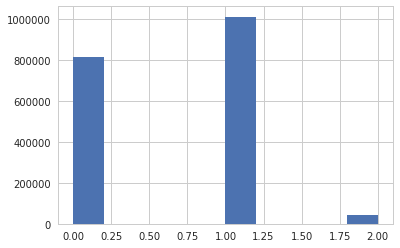

In [56]:
train.target.hist()

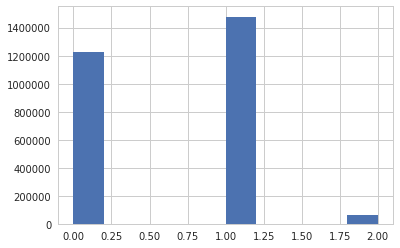

In [57]:
test.target.hist()

In [58]:
test.head(100)

,id,fullname,country,char_cnt,word_cnt,proba_1,proba_2,proba_3,target
0,0,ХУДАШКУРОВА ГУЛЗХОДА БЕРДИЕВНА,УЗБЕКИСТАН,30,3,8.488318e-04,9.991498e-01,1.320520e-06,1
1,1,СВЕЖЕТЬФЛОГИСТОН АРСЕН,РОССИЯ,22,2,1.706763e-04,1.389892e-03,9.984395e-01,2
2,2,ГУЛОМОВА СОЖИДА САНАЕВНА,УЗБЕКИСТАН,24,3,8.760267e-01,1.239706e-01,2.565175e-06,0
3,3,КАМПЫШЕВА ГУЛЯИМ БЕЙСЕМБАЕВНА,КАЗАХСТАН,29,3,3.300656e-01,6.698200e-01,1.144526e-04,1
4,4,OROSUMEBTOV MIRLAN,РОССИЯ,18,2,3.744606e-02,9.624528e-01,1.010562e-04,1
5,5,ГОТОВЕНЬКИЙ НЕЛИКВИДНЫЙ СВОЛОЧЬ,РОССИЯ,31,3,1.627097e-08,2.031603e-09,1.000000e+00,2
6,6,РЕШЕТНИКОВ АЛАЕКСАНДР,КАЗАХСТАН,21,2,8.007829e-05,9.999197e-01,1.840590e-07,1
7,7,КУРБАНОВА ШАКИРАБАХОДИРОВНА,УЗБЕКИСТАН,27,2,8.848592e-10,1.000000e+00,0.000000e+00,1
8,8,АМОНЛИКОВ РСУТАМ ЭШОНОВИЧ,ТАДЖИКИСТАН,25,3,7.277039e-05,9.999272e-01,8.749014e-08,1
9,9,ЗЫРЯЕОВ АЛЕКСАНДР КОНСТАНТИНОВИЧ,УЗБЕКИСТАН,32,3,4.147860e-04,9.995847e-01,4.892332e-07,1


In [201]:
max_len_char

50

In [59]:
test.to_csv('test20102018_cnn_bidirect_64_80_128_proba.csv', sep=';', index=False)

### BidirectGRU+Conv1D
Попробуем соединить прошлый подход с bidirect-GRU

In [37]:
def get_model():
    input_char=Input(shape=(max_len_char,),  dtype='int32')
    embed_size=200
    x=Embedding(len(tokenizer_char.word_index)+1,
                embed_size, 
                input_length=max_len_char)(input_char)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(80, return_sequences=True))(x)
    
    conv1 = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
    conv2=  Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "glorot_uniform")(x)
    conv3 = Conv1D(64, kernel_size = 5, padding = "valid", kernel_initializer = "glorot_uniform")(x)

    avg_pool1 = GlobalAveragePooling1D()(conv1)
    max_pool1 = GlobalMaxPooling1D()(conv1)
    
    avg_pool2 = GlobalAveragePooling1D()(conv2)
    max_pool2 = GlobalMaxPooling1D()(conv2)
    
    avg_pool3 = GlobalAveragePooling1D()(conv3)
    max_pool3 = GlobalMaxPooling1D()(conv3)
    
    x = concatenate([avg_pool1, max_pool1, avg_pool2, max_pool2, avg_pool3, max_pool3])
    x = Dropout(0.2)(x)
    x = Dense(512, activation='relu')(x)
    #x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    #x = Dropout(0.2)(x)
    x = Dense(3)(x)
    output = Activation('softmax')(x)

    model = Model(inputs=[input_char], outputs=[output])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [38]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 200)      17400       input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 50, 200)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 50, 160)      134880      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
conv1d_1 (

In [39]:
%%time
batch_size = 128
epochs = 15

print(u'Тренируем модель...')
history = model.fit(x_t_ch, y_t,
          batch_size=batch_size,
          epochs=epochs, verbose=1,
          validation_data=(x_te_ch, y_te), shuffle=True)

Тренируем модель...
Train on 1400730 samples, validate on 466910 samples
Epoch 1/15
1400730/1400730 [==============================] - 1797s 1ms/step - loss: 0.3893 - acc: 0.8221 - val_loss: 0.3060 - val_acc: 0.8753
Epoch 2/15
1280768/1400730 [==========================>...] - ETA: 2:21 - loss: 0.2881 - acc: 0.8833

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 942848/1400730 [===================>..........] - ETA: 8:58 - loss: 0.2586 - acc: 0.8980

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 617600/1400730 [============>.................] - ETA: 15:17 - loss: 0.2437 - acc: 0.9056

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1400730/1400730 [==============================] - 1776s 1ms/step - loss: 0.2416 - acc: 0.9064 - val_loss: 0.2397 - val_acc: 0.9084
Epoch 5/15
 292608/1400730 [=====>........................] - ETA: 21:33 - loss: 0.2312 - acc: 0.9106

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1357184/1400730 [============================>.] - ETA: 51s - loss: 0.2310 - acc: 0.9111

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1083264/1400730 [======================>.......] - ETA: 6:12 - loss: 0.2243 - acc: 0.9140

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 807808/1400730 [================>.............] - ETA: 11:35 - loss: 0.2189 - acc: 0.9161

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 397696/1400730 [=======>......................] - ETA: 19:32 - loss: 0.2115 - acc: 0.9193

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1400730/1400730 [==============================] - 1782s 1ms/step - loss: 0.2141 - acc: 0.9184 - val_loss: 0.2115 - val_acc: 0.9203
Epoch 9/15
 119296/1400730 [=>............................] - ETA: 24:58 - loss: 0.2083 - acc: 0.9207

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1146624/1400730 [=======================>......] - ETA: 4:58 - loss: 0.2110 - acc: 0.9197

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 821632/1400730 [================>.............] - ETA: 11:18 - loss: 0.2070 - acc: 0.9211

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 492928/1400730 [=========>....................] - ETA: 17:44 - loss: 0.2036 - acc: 0.9225

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1400730/1400730 [==============================] - 1778s 1ms/step - loss: 0.2057 - acc: 0.9217 - val_loss: 0.2039 - val_acc: 0.9230
Epoch 12/15
 171648/1400730 [==>...........................] - ETA: 24:06 - loss: 0.2014 - acc: 0.9232

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1254144/1400730 [=========================>....] - ETA: 2:52 - loss: 0.2030 - acc: 0.9229

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 931072/1400730 [==================>...........] - ETA: 9:11 - loss: 0.2005 - acc: 0.9240

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 605696/1400730 [===========>..................] - ETA: 15:32 - loss: 0.1975 - acc: 0.9251

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1400730/1400730 [==============================] - 1782s 1ms/step - loss: 0.1994 - acc: 0.9242 - val_loss: 0.2068 - val_acc: 0.9223
Epoch 15/15
 270336/1400730 [====>.........................] - ETA: 22:10 - loss: 0.1934 - acc: 0.9265

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1336704/1400730 [===========================>..] - ETA: 1:15 - loss: 0.1979 - acc: 0.9248

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Train ALL

In [48]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [63]:
model = get_model()
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [ ]:
%%time
batch_size = 128 #128 лучшее локально, но хуже по лб
epochs = 20 # 13 эпохи лучшее

print(u'Тренируем модель...')
history = model.fit(
    x_all_ch, 
    y_all,
    batch_size=batch_size,
    epochs=epochs, shuffle=True
)

Тренируем модель...
Epoch 1/20
 502656/1867640 [=======>......................] - ETA: 26:36 - loss: 0.4681 - acc: 0.7697

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1340288/1867640 [====================>.........] - ETA: 10:16 - loss: 0.3901 - acc: 0.8216

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1867640/1867640 [==============================] - 2186s 1ms/step - loss: 0.3647 - acc: 0.8374
Epoch 2/20
 359040/1867640 [====>.........................] - ETA: 29:18 - loss: 0.2834 - acc: 0.8855

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1363584/1867640 [====================>.........] - ETA: 9:48 - loss: 0.2720 - acc: 0.8918

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 484992/1867640 [======>.......................] - ETA: 26:59 - loss: 0.2472 - acc: 0.9039

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1867640/1867640 [==============================] - 2180s 1ms/step - loss: 0.2424 - acc: 0.9058
Epoch 4/20
1867640/1867640 [==============================] - 2181s 1ms/step - loss: 0.2291 - acc: 0.9118
Epoch 5/20
1867640/1867640 [==============================] - 2182s 1ms/step - loss: 0.2206 - acc: 0.9154
Epoch 6/20
1867640/1867640 [==============================] - 2189s 1ms/step - loss: 0.2147 - acc: 0.9179
Epoch 7/20
1867640/1867640 [==============================] - 2186s 1ms/step - loss: 0.2103 - acc: 0.9198
Epoch 8/20
1867640/1867640 [==============================] - 2181s 1ms/step - loss: 0.2070 - acc: 0.9211
Epoch 9/20
1867640/1867640 [==============================] - 2181s 1ms/step - loss: 0.2041 - acc: 0.9224
Epoch 10/20
1867640/1867640 [==============================] - 2187s 1ms/step - loss: 0.2018 - acc: 0.9233
Epoch 11/20
1867640/1867640 [==============================] - 2182s 1ms/step - loss: 0.1997 - acc: 0.9242
Epoch 12/20
1867640/1867640 [==========================